# Approch with simple resnet

In [57]:
files= [i.split('.')[0] for i in os.listdir(r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\xml_labels')]

In [58]:
files

['S1_Cheese_C1',
 'S1_Coffee_C1',
 'S1_CofHoney_C1',
 'S1_Hotdog_C1',
 'S1_Pealate_C1',
 'S1_Peanut_C1',
 'S1_Tea_C1',
 'S2_Cheese_C1',
 'S2_Coffee_C1',
 'S2_CofHoney_C1',
 'S2_Hotdog_C1',
 'S2_Pealate_C1',
 'S2_Peanut_C1',
 'S2_Tea_C1',
 'S3_Cheese_C1',
 'S3_Coffee_C1',
 'S3_CofHoney_C1',
 'S3_Hotdog_C1',
 'S3_Pealate_C1',
 'S3_Peanut_C1',
 'S3_Tea_C1',
 'S4_Cheese_C1',
 'S4_Coffee_C1',
 'S4_CofHoney_C1',
 'S4_Hotdog_C1',
 'S4_Pealate_C1',
 'S4_Peanut_C1',
 'S4_Tea_C1']

In [70]:
import os
import xml.etree.ElementTree as ET
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader, random_split

class IntegratedVideoDataset(Dataset):
    def __init__(self, 
                 xml_dir='xml_labels',
                 image_dir='png',
                 actions_dir='actions',
                 action_mapping=None,
                 transform=None):
        """
        This dataset integrates the functionality from previous code snippets:
        - Reads multiple videos from directories of frames.
        - Parses corresponding XML annotations for bounding boxes and keypoints.
        - Loads action labels from corresponding .txt files.
        - Returns 3-frame snippets (t-1, t, t+1) along with boxes, keypoints, and action label.
        - Images are read as grayscale and transformed similarly to previous code.
        
        Args:
            xml_dir (str): Directory containing the XML annotation files (one per video).
            image_dir (str): Directory containing image folders for each video.
            actions_dir (str): Directory containing action .txt files (one per video).
            action_mapping (dict): Mapping from action strings to integers.
            transform (callable): Optional transform to apply to each frame.
        """
        self.xml_dir = xml_dir
        self.image_dir = image_dir
        self.actions_dir = actions_dir

        # Default action mapping if not provided
        if action_mapping is None:
            self.action_mapping = {
                'take': 0, 'open': 1, 'pour': 2, 'close': 3, 'shake': 4,
                'scoop': 5, 'stir': 6, 'put': 7, 'fold': 8, 'spread': 9, 'background': 10
            }
        else:
            self.action_mapping = action_mapping

        # Default transform if not provided
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485], std=[0.229])  # Grayscale normalization
            ])
        else:
            self.transform = transform

        # Parse all videos: load their annotations, frames, and actions
        self.samples = self.parse_all_videos()

    def parse_all_videos(self):
        """
        Parse all XML files in xml_dir. For each video:
        - Extract boxes, keypoints per frame.
        - Load corresponding actions.txt file.
        - Store records as a list of dicts: {video_name, frame_idx, frame_name, boxes, keypoints, action_label}
        Finally, combine all videos into one list and sort them for linear indexing.
        """
        samples = []

        xml_files = [f for f in os.listdir(self.xml_dir) if f.endswith('.xml')]
        for xml_name in xml_files:
            video_name = xml_name.replace('.xml', '')

            xml_path = os.path.join(self.xml_dir, xml_name)
            if not os.path.exists(xml_path):
                continue

            # Load annotations from XML
            annotations = self._load_annotations(xml_path)

            # Try to load actions
            actions_path = os.path.join(self.actions_dir, video_name + '.txt')
            if not os.path.exists(actions_path):
                # If no actions file, we can fill with 'background' or skip
                # Here we assume background if missing
                num_frames = max(annotations.keys())+1 if annotations else 0
                actions = ['background'] * num_frames
            else:
                actions = self._load_actions(actions_path)

            # Convert action strings to int
            actions = [self.action_mapping.get(a, self.action_mapping['background']) for a in actions]

            # For each frame in annotations, store record
            # Frame indexing: we assume frame_id keys from annotations are int frame indices
            # Need to ensure we do not exceed action indexing if there's mismatch
            sorted_keys = sorted(annotations.keys())
            for frame_id in sorted_keys:
                if frame_id >= len(actions):
                    # If more annotation frames than actions, use last action as fallback
                    action_label = actions[-1]
                else:
                    action_label = actions[frame_id]

                frame_name = annotations[frame_id].get("frame_name", f"frame_{frame_id}")
                boxes = annotations[frame_id]["boxes"]
                keypoints = annotations[frame_id]["keypoints"]

                samples.append({
                    'video_name': video_name,
                    'frame_idx': frame_id,
                    'frame_name': frame_name,
                    'boxes': boxes,
                    'keypoints': keypoints,
                    'action': action_label
                })

        # Sort samples by video_name and frame_idx for consistent indexing
        samples.sort(key=lambda x: (x['video_name'], x['frame_idx']))
        return samples

    def _load_actions(self, action_txt_path):
        with open(action_txt_path, "r") as f:
            actions = [line.strip() for line in f.readlines()]
        return actions

    def _load_annotations(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        annotations = defaultdict(lambda: {"boxes": [], "keypoints": [], "frame_name": None})

        for image in root.findall("image"):
            frame_id_str = image.get("id")
            # Frame id might be numeric or like 'frame_0001'
            # Try to parse integer directly, otherwise strip 'frame_'
            try:
                frame_id = int(frame_id_str)
            except ValueError:
                # remove any non-digit prefix
                frame_id = int(''.join(filter(str.isdigit, frame_id_str)))

            frame_name = image.get("name", f"frame_{frame_id}")
            annotations[frame_id]["frame_name"] = frame_name

            for box in image.findall("box"):
                xtl = float(box.get("xtl"))
                ytl = float(box.get("ytl"))
                xbr = float(box.get("xbr"))
                ybr = float(box.get("ybr"))
                annotations[frame_id]["boxes"].append([xtl, ytl, xbr, ybr])

            for polyline in image.findall("polyline"):
                points = polyline.get("points")
                points = [tuple(map(float, point.split(",")))
                          for point in points.split(";") if point.strip()]
                annotations[frame_id]["keypoints"].append(points)

        return annotations

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Get the sample at idx
        sample = self.samples[idx]
        video_name = sample['video_name']
        frame_idx = sample['frame_idx']
        frame_name = sample['frame_name']
        boxes = sample['boxes']
        keypoints = sample['keypoints']
        action = sample['action']

        # We want to return 3-frame snippet: t-1, t, t+1
        # Find neighbors
        prev_idx = self._find_neighbor(video_name, frame_idx - 1)
        next_idx = self._find_neighbor(video_name, frame_idx + 1)

        # If no previous frame, use current
        if prev_idx is None:
            prev_idx = idx
        # If no next frame, use current
        if next_idx is None:
            next_idx = idx

        # Load frames and annotations for prev, current, next
        frames_list = [self.samples[prev_idx], self.samples[idx], self.samples[next_idx]]

        sequence_frames = []
        sequence_boxes = []
        sequence_keypoints = []

        for fr in frames_list:
            img_path = os.path.join(self.image_dir, fr['video_name'], fr['frame_name'] + '.png')
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            # Transform image
            image = self.transform(image)  # (1,224,224)

            # Boxes
            curr_boxes = torch.tensor(fr['boxes']).float()
            if len(curr_boxes) < 2:
                # Pad boxes with zeros
                curr_boxes = torch.cat([curr_boxes, torch.zeros((2 - len(curr_boxes), 4))])

            # Keypoints
            # keypoints is a list of lists of points. Flatten them
            all_kpts = [(kp[0], kp[1]) for kps in fr['keypoints'] for kp in kps]
            curr_kpts = torch.tensor(all_kpts).float()
            if len(curr_kpts) < 42:
                curr_kpts = torch.cat([curr_kpts, torch.zeros((42 - len(curr_kpts), 2))])

            sequence_frames.append(image)
            sequence_boxes.append(curr_boxes)
            sequence_keypoints.append(curr_kpts)

        # Stack them: (3,1,224,224), (3,2,4), (3,42,2)
        frames_tensor = torch.stack(sequence_frames)
        boxes_tensor = torch.stack(sequence_boxes)
        kpts_tensor = torch.stack(sequence_keypoints)

        return frames_tensor, boxes_tensor, kpts_tensor, action

    def _find_neighbor(self, video_name, frame_id):
        """
        Given a video_name and a frame_id, find the index in self.samples that matches.
        Return None if not found.
        """
        # Binary search could be used here, but for simplicity just linear search
        # Since self.samples is sorted, we can do a more efficient approach:
        # We'll just search in a filtered view. This is O(n). For large datasets,
        # consider indexing by video_name.
        # We'll create a quick index map at init if needed. For now, keep simple.

        # A simple approach: since sorted by video_name, find the range for this video.
        # We'll do a binary search approach here for clarity.
        # But let's keep it simple (linear) for demonstration:
        for i, s in enumerate(self.samples):
            if s['video_name'] == video_name and s['frame_idx'] == frame_id:
                return i
        return None




In [ ]:
# Example usage (pseudo-code, adjust paths accordingly)
xml_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\xml_labels'
image_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\gtea_png\gtea_png\png'
actions_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\actions-20241207T081235Z-001\actions'


dataset = IntegratedVideoDataset(xml_dir=xml_dir, image_dir=image_dir, actions_dir=actions_dir)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Check shapes
for frames, boxes, keypoints, actions in train_loader:
    print("Frames shape:", frames.shape)       # (B,3,1,224,224)
    print("Boxes shape:", boxes.shape)         # (B,3,2,4)
    print("Keypoints shape:", keypoints.shape) # (B,3,42,2)
    print("Actions shape:", actions.shape)     # (B)
    break


Parsing 1633 total annotations for S1_Cheese_C1.xml
Parsing 1831 total annotations for S1_Coffee_C1.xml
Parsing 1941 total annotations for S1_CofHoney_C1.xml
Parsing 1231 total annotations for S1_Hotdog_C1.xml
Parsing 2165 total annotations for S1_Pealate_C1.xml
Parsing 2408 total annotations for S1_Peanut_C1.xml
Parsing 2708 total annotations for S1_Tea_C1.xml
Parsing 1114 total annotations for S2_Cheese_C1.xml
Parsing 2911 total annotations for S2_Coffee_C1.xml
Parsing 1314 total annotations for S2_CofHoney_C1.xml
Parsing 1471 total annotations for S2_Hotdog_C1.xml
Parsing 2006 total annotations for S2_Pealate_C1.xml
Parsing 2395 total annotations for S2_Peanut_C1.xml
Parsing 1938 total annotations for S2_Tea_C1.xml
Parsing 1690 total annotations for S3_Cheese_C1.xml
Parsing 2076 total annotations for S3_Coffee_C1.xml
Parsing 1560 total annotations for S3_CofHoney_C1.xml
Parsing 1655 total annotations for S3_Hotdog_C1.xml
Parsing 2206 total annotations for S3_Pealate_C1.xml
Parsing 1

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import torch.optim as optim


class CustomResNet(nn.Module):
    def __init__(self, num_actions=11):
        super(CustomResNet, self).__init__()
        
        # Linear layers to map bounding boxes and keypoints to 224x224
        # Bounding boxes: For each frame: 2 boxes * 4 coords = 8 dims
        # Keypoints: For each frame: 42 keypoints * 2 coords = 84 dims
        
        self.fc_boxes = nn.Linear(8, 224)
        self.fc_keypoints = nn.Linear(84, 224)
        
        # After concatenation: 224 (from boxes) + 224 (from keypoints) = 448
        # Map 448 -> 224*224 = 50176
        self.fc_combined = nn.Linear(448, 224 * 224)
        
        # Modify ResNet to accept 4 input channels instead of 3
        self.base_model = resnet18(pretrained=False)
        self.base_model.conv1 = nn.Conv2d(
            in_channels=2, out_channels=64, kernel_size=7,
            stride=2, padding=3, bias=False
        )
        
        self.base_model.fc = nn.Linear(512, num_actions)

    def forward(self, frames, boxes, keypoints):
        """
        Args:
            frames: (B, T, 3, 224, 224)
            boxes: (B, T, 2, 4)
            keypoints: (B, T, 42, 2)
        """
        
        B, T, C, H, W = frames.size()  # frames: B,T,3,224,224
        # Flatten bounding boxes and keypoints per frame
        # boxes -> (B,T,8)
        # keypoints -> (B,T,84)
        boxes_flat = boxes.view(B, T, -1)       # (B,T,8)
        kpts_flat = keypoints.view(B, T, -1)    # (B,T,84)

        # Process each frame in the time dimension
        new_frames = []
        for t in range(T):
            boxes_t = boxes_flat[:, t, :]      # (B,8)
            kpts_t = kpts_flat[:, t, :]        # (B,84)
            frame_t = frames[:, t, :, :, :]    # (B,3,224,224)
            
            # Map boxes_t and kpts_t
            box_feats = self.fc_boxes(boxes_t)         # (B,224)
            kpts_feats = self.fc_keypoints(kpts_t)     # (B,224)
            
            combined = torch.cat([box_feats, kpts_feats], dim=1)  # (B,448)
            combined = self.fc_combined(combined)                 # (B,50176)
            
            # Reshape to (B,224,224)
            combined_map = combined.view(B, 224, 224)  # (B,224,224)
            
            # Normalize the combined_map channel
            # Compute mean and std along spatial dimensions for each sample.
            mean = combined_map.mean(dim=(1, 2), keepdim=True)
            std = combined_map.std(dim=(1, 2), keepdim=True) + 1e-8
            combined_map = (combined_map - mean) / std

            # Add channel dimension back: (B,1,224,224)
            combined_map = combined_map.unsqueeze(1)
            
            # Concatenate along channel dimension: (B,4,224,224)
            enhanced_frame = torch.cat([frame_t, combined_map], dim=1)
            new_frames.append(enhanced_frame)
        
        # (B,T,4,224,224)
        enhanced_frames = torch.stack(new_frames, dim=1)
        
        # Process each frame with ResNet and average the final logits
        logits_list = []
        for t in range(T):
            logits = self.base_model(enhanced_frames[:, t, :, :, :])
            logits_list.append(logits)
        
        # Average the logits over time: (B,num_actions)
        final_logits = torch.mean(torch.stack(logits_list, dim=0), dim=0)
        
        return final_logits





model = CustomResNet(num_actions=11)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [73]:
from sklearn.metrics import accuracy_score, f1_score

num_epochs = 20

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0.0
    all_preds = []
    all_targets = []

    for i, (frames, boxes, keypoints, actions) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(frames, boxes, keypoints)  # (B, num_actions)
        loss = criterion(outputs, actions)
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Predictions and targets for metrics
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        targets = actions.cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(targets)

    # Compute training metrics for the epoch
    train_mean_loss = epoch_loss / len(train_loader)
    train_accuracy = accuracy_score(all_targets, all_preds)
    train_f1 = f1_score(all_targets, all_preds, average='weighted')

    print(f"Epoch {epoch} - Train Loss: {train_mean_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}")

    # Evaluation phase
    model.eval()
    test_loss = 0.0
    test_preds = []
    test_targets = []

    with torch.no_grad():
        for i, (frames, boxes, keypoints, actions) in enumerate(test_loader):
            outputs = model(frames, boxes, keypoints)
            loss = criterion(outputs, actions)

            test_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            targets = actions.cpu().numpy()
            test_preds.extend(preds)
            test_targets.extend(targets)

    # Compute test metrics for the epoch
    test_mean_loss = test_loss / len(test_loader)
    test_accuracy = accuracy_score(test_targets, test_preds)
    test_f1 = f1_score(test_targets, test_preds, average='weighted')

    print(f"Epoch {epoch} - Test Loss: {test_mean_loss:.4f}, "
          f"Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}")


KeyboardInterrupt: 

# Approch with temporal data and lstms

In [77]:
import os
import cv2
import torch
import numpy as np
import xml.etree.ElementTree as ET
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import gaussian_filter
from sklearn.metrics import accuracy_score, f1_score

# Action mapping
ACTION_MAPPING = {
    'take': 0, 'open': 1, 'pour': 2, 'close': 3, 'shake': 4,
    'scoop': 5, 'stir': 6, 'put': 7, 'fold': 8, 'spread': 9, 'background': 10
}

def draw_box_mask(boxes, H=224, W=224):
    """Create a binary mask for bounding boxes."""
    mask = np.zeros((H, W), dtype=np.float32)
    for box in boxes:
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(W-1, x2), min(H-1, y2)
        mask[y1:y2+1, x1:x2+1] = 1.0
    return mask

def draw_keypoint_heatmap(keypoints, H=224, W=224, sigma=3):
    """Create a heatmap from keypoints using Gaussian spots."""
    heatmap = np.zeros((H, W), dtype=np.float32)
    for (x, y) in keypoints:
        x, y = int(x), int(y)
        if 0 <= x < W and 0 <= y < H:
            heatmap[y, x] = 1.0
    # Apply Gaussian blur to spread out the keypoint signal
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    # Normalize if needed
    if heatmap.max() > 0:
        heatmap /= heatmap.max()
    return heatmap

class IntegratedVideoDataset(Dataset):
    def __init__(self, xml_dir, image_dir, actions_dir, action_mapping=ACTION_MAPPING):
        self.xml_dir = xml_dir
        self.image_dir = image_dir
        self.actions_dir = actions_dir
        self.action_mapping = action_mapping
        self.samples = self.parse_all_videos()

    def parse_all_videos(self):
        samples = []
        xml_files = [f for f in os.listdir(self.xml_dir) if f.endswith('.xml')]
        for xml_name in xml_files:
            video_name = xml_name.replace('.xml', '')
            xml_path = os.path.join(self.xml_dir, xml_name)

            if not os.path.exists(xml_path):
                continue

            annotations = self._load_annotations(xml_path)

            # Try to load actions
            actions_path = os.path.join(self.actions_dir, video_name + '.txt')
            if not os.path.exists(actions_path):
                num_frames = max(annotations.keys())+1 if annotations else 0
                actions = ['background'] * num_frames
            else:
                actions = self._load_actions(actions_path)

            # Convert action strings to int
            actions = [self.action_mapping.get(a, self.action_mapping['background']) for a in actions]

            # Store samples
            sorted_keys = sorted(annotations.keys())
            for frame_id in sorted_keys:
                if frame_id >= len(actions):
                    action_label = actions[-1]
                else:
                    action_label = actions[frame_id]

                frame_name = annotations[frame_id].get("frame_name", f"frame_{frame_id}")
                boxes = annotations[frame_id]["boxes"]
                keypoints = annotations[frame_id]["keypoints"]

                samples.append({
                    'video_name': video_name,
                    'frame_idx': frame_id,
                    'frame_name': frame_name,
                    'boxes': boxes,
                    'keypoints': keypoints,
                    'action': action_label
                })

        # Sort samples by video_name and frame_idx
        samples.sort(key=lambda x: (x['video_name'], x['frame_idx']))
        return samples

    def _load_actions(self, action_txt_path):
        with open(action_txt_path, "r") as f:
            actions = [line.strip() for line in f.readlines()]
        return actions

    def _load_annotations(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        annotations = defaultdict(lambda: {"boxes": [], "keypoints": [], "frame_name": None})

        for image in root.findall("image"):
            frame_id_str = image.get("id")
            try:
                frame_id = int(frame_id_str)
            except ValueError:
                frame_id = int(''.join(filter(str.isdigit, frame_id_str)))

            frame_name = image.get("name", f"frame_{frame_id}")
            annotations[frame_id]["frame_name"] = frame_name

            for box in image.findall("box"):
                xtl = float(box.get("xtl"))
                ytl = float(box.get("ytl"))
                xbr = float(box.get("xbr"))
                ybr = float(box.get("ybr"))
                annotations[frame_id]["boxes"].append([xtl, ytl, xbr, ybr])

            for polyline in image.findall("polyline"):
                points = polyline.get("points")
                points = [tuple(map(float, point.split(",")))
                          for point in points.split(";") if point.strip()]
                annotations[frame_id]["keypoints"].append(points)

        return annotations

    def __len__(self):
        return len(self.samples)

    def _find_neighbor(self, video_name, frame_id):
        # Find sample with same video_name and frame_id
        # Since samples are sorted, we can do a simple search
        # For large datasets, consider indexing
        for i, s in enumerate(self.samples):
            if s['video_name'] == video_name and s['frame_idx'] == frame_id:
                return i
        return None

    def __getitem__(self, idx):
        sample = self.samples[idx]
        video_name = sample['video_name']
        frame_idx = sample['frame_idx']

        # Neighbors: t-1 and t+1
        prev_idx = self._find_neighbor(video_name, frame_idx - 1)
        next_idx = self._find_neighbor(video_name, frame_idx + 1)
        if prev_idx is None:
            prev_idx = idx
        if next_idx is None:
            next_idx = idx

        frames_info = [self.samples[prev_idx], sample, self.samples[next_idx]]

        frames_tensor = []
        for fr in frames_info:
            img_path = os.path.join(self.image_dir, fr['video_name'], fr['frame_name'] + '.png')
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                image = np.zeros((224,224), dtype=np.uint8)
            else:
                image = cv2.resize(image, (224,224))

            boxes = fr['boxes']      # list of [x1,y1,x2,y2]
            kpts_list = fr['keypoints']  # list of list of points
            kpts = []
            for kps in kpts_list:
                kpts.extend(kps)

            box_mask = draw_box_mask(boxes, H=224, W=224)
            kp_heatmap = draw_keypoint_heatmap(kpts, H=224, W=224, sigma=3)

            # Normalize image channel
            gray_frame = image.astype(np.float32)/255.0

            # Stack into 3 channels
            frame_3ch = np.stack([gray_frame, box_mask, kp_heatmap], axis=0)  # (3,224,224)

            # Convert to torch
            frame_3ch = torch.tensor(frame_3ch)

            # Simple normalization (you can tune these)
            # mean and std per channel
            mean = torch.tensor([0.45, 0.0, 0.0]).view(3,1,1)
            std = torch.tensor([0.225,0.225,0.225]).view(3,1,1)
            frame_3ch = (frame_3ch - mean)/std

            frames_tensor.append(frame_3ch)

        frames_tensor = torch.stack(frames_tensor, dim=0)  # (T,3,224,224)
        action = sample['action']

        # Boxes and keypoints placeholders (not used)
        boxes_tensor = torch.zeros(3,2,4)
        keypoints_tensor = torch.zeros(3,42,2)

        return frames_tensor, boxes_tensor, keypoints_tensor, action


class SpatialTemporalModel(nn.Module):
    def __init__(self, num_actions=11, hidden_dim=512, num_layers=1):
        super(SpatialTemporalModel, self).__init__()
        
        # Base ResNet for spatial feature extraction
        self.base_model = resnet18(pretrained=False)
        # Adapt first conv layer for 3 channels
        self.base_model.conv1 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.base_model.fc = nn.Identity()  # output 512 features

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        
        # Final classifier
        self.classifier = nn.Linear(hidden_dim, num_actions)

    def forward(self, frames, boxes=None, keypoints=None):
        # frames: (B,T,3,224,224)
        B,T,C,H,W = frames.size()
        frames_flat = frames.view(B*T, C, H, W)
        spatial_feats = self.base_model(frames_flat)  # (B*T,512)
        spatial_feats = spatial_feats.view(B,T,512)

        out, (h,c) = self.lstm(spatial_feats)  # (B,T,hidden_dim)
        final_feat = out[:, -1, :]  # use last frame's output

        logits = self.classifier(final_feat)
        return logits


if __name__ == "__main__":
    # Adjust paths
    xml_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\xml_labels'
    image_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\gtea_png\gtea_png\png'
    actions_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\actions-20241207T081235Z-001\actions'

    dataset = IntegratedVideoDataset(xml_dir=xml_dir, image_dir=image_dir, actions_dir=actions_dir)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

    model = SpatialTemporalModel(num_actions=11)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    num_epochs = 20
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        all_preds = []
        all_targets = []

        for i, (frames, boxes, keypoints, actions) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(frames)  # (B, num_actions)
            loss = criterion(outputs, actions)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            targets = actions.cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(targets)

        train_mean_loss = epoch_loss / len(train_loader)
        train_accuracy = accuracy_score(all_targets, all_preds)
        train_f1 = f1_score(all_targets, all_preds, average='weighted')
        print(f"Epoch {epoch} - Train Loss: {train_mean_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}")

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        test_preds = []
        test_targets = []

        with torch.no_grad():
            for i, (frames, boxes, keypoints, actions) in enumerate(test_loader):
                outputs = model(frames)
                loss = criterion(outputs, actions)

                test_loss += loss.item()
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                targets = actions.cpu().numpy()
                test_preds.extend(preds)
                test_targets.extend(targets)

        test_mean_loss = test_loss / len(test_loader)
        test_accuracy = accuracy_score(test_targets, test_preds)
        test_f1 = f1_score(test_targets, test_preds, average='weighted')
        print(f"Epoch {epoch} - Test Loss: {test_mean_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}")


KeyboardInterrupt: 

# keypoint

In [83]:
import os
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
import cv2 

class HandKeypointDataset(Dataset):
    def __init__(self, xml_path='xml_labels', image_dir='png', transform=None):
        """
        Args:
            xml_path (str): Path to the XML annotation folder.
            image_dir (str): Directory containing corresponding image files.
            transform (callable, optional): Transform to be applied on the images.
        """
        self.xml_path = xml_path
        self.image_dir = image_dir
        self.transform = transform
        self.annotations = self.parse_xml()

    def parse_xml(self):
        """Parses the XML file and extracts annotations."""
        complete_dataset = []

        for xml_name in os.listdir(self.xml_path): 
            xml_path = os.path.join(self.xml_path, xml_name)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            num_annos = len(root.findall('image'))
            all_annos = root.findall('image')
            print(f"Parsing {num_annos} total annotations for {xml_name}")
            
            for i in range(num_annos):
                boxes = {'left':[], 'right':[]}
                keypoints = {'left':{}, 'right':{}}

                curr_annos = []
                for anno in all_annos: 
                    try:
                        if int(anno.get('id')) == int(all_annos[i].get('id')):
                            curr_annos.append(anno)
                    except ValueError:
                        # print(f"WARNING: Found strings in image ids for xml: {xml_name}")
                        if int(anno.get('id').replace('frame_', '')) == int(all_annos[i].get('id').replace('frame_', '')):
                            curr_annos.append(anno)

                annos = {curr_anno.findall('box')[0].findall(".//attribute[@name='hand_type']")[0].text: curr_anno for curr_anno in curr_annos}
                
                if len(annos.keys()) < 2:
                    continue

                width = int(annos['left'].get('width'))
                height = int(annos['right'].get('height'))

                for anno_side, anno_val in annos.items():
                    for box in anno_val.findall('box'):
                        xtl = float(box.get('xtl'))
                        ytl = float(box.get('ytl'))
                        xbr = float(box.get('xbr'))
                        ybr = float(box.get('ybr'))
                        label = box.get('label')

                        boxes[anno_side].append({'label': label, 'bbox': [xtl, ytl, xbr, ybr]})

                    for polyline in anno_val.findall('polyline'):
                        label = polyline.get('label')
                        points = [
                            tuple(map(float, point.split(',')))
                            for point in polyline.get('points').split(';')
                        ]
                        keypoints[anno_side][label] = points

                complete_dataset.append(
                    {
                        'id': annos['left'].get('id'),
                        'video_name': xml_name.replace('.xml', ''),
                        'frame_name': annos['left'].get('name'),
                        'width': width,
                        'height': height,
                        'boxes': boxes,
                        'keypoints': keypoints
                    }
                )

        return complete_dataset

    def __len__(self):
        return len(self.annotations)
    
    def plot_annotations(self, image, boxes, keypoints):
        """
        Plots bounding boxes and keypoints on the image using OpenCV.

        Args:
            image_path (str): Path to the image file.
            boxes (dict): Dictionary containing bounding boxes in the format:
                        {'left': [{'label': 'hand', 'bbox': [x_min, y_min, x_max, y_max]}], 'right': ...}
            keypoints (dict): Dictionary containing keypoints in the format:
                            {'left': {'thumb': [(x1, y1), (x2, y2), ...], ...}, 'right': ...}
        """

        for hand_side, hand_boxes in boxes.items():
            for box_info in hand_boxes:
                x_min, y_min, x_max, y_max = map(int, box_info['bbox'])
                label = box_info['label']
                color = (0, 255, 0) if hand_side == 'left' else (255, 0, 0)
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
                cv2.putText(image, f"{label} ({hand_side})", (x_min, y_min - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        for hand_side, hand_keypoints in keypoints.items():
            for finger, points in hand_keypoints.items():
                color = (0, 255, 255) if hand_side == 'left' else (255, 255, 0)
                for point in points:
                    x, y = map(int, point)
                    cv2.circle(image, (x, y), 3, color, -1)
                for i in range(len(points) - 1):
                    pt1 = tuple(map(int, points[i]))
                    pt2 = tuple(map(int, points[i + 1]))
                    cv2.line(image, pt1, pt2, color, 2)
        return image 

    def __getitem__(self, idx):
        
        # Get annotation

        image_path = os.path.join(self.image_dir, self.annotations[idx]['video_name'], self.annotations[idx]['frame_name']+'.png')
        image = cv2.imread(image_path)

        ### visualize if you want
        # plotted = self.plot_annotations(image, self.annotations[idx]['boxes'], self.annotations[idx]['keypoints'])
        # cv2.imwrite('test.png', plotted)

        ### your transformations  

        return image, self.annotations[idx]

# dataset = HandKeypointDataset()
# dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

# set batch_size = 1 and plot a video of your annotations if you want
# video_filename = 'aaa.avi'
# frame_width, frame_height = 720, 405  
# fps = 15  
# fourcc = cv2.VideoWriter_fourcc(*'XVID')  
# out = cv2.VideoWriter(video_filename, fourcc, fps, (frame_width, frame_height))

# for idx,batch in enumerate(dataloader):
#     img = batch[0].squeeze().numpy()
#     if len(img.shape) == 2:
#         img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
#     elif img.shape[-1] != 3:
#         raise ValueError("Images must have 3 channels for BGR format")
#     try:
#         img_resized = cv2.resize(img, (frame_width, frame_height))
#     except:
#         import pdb; pdb.set_trace()
         
#     out.write(img_resized)

# out.release()
# print(f"Video saved as {video_filename}")


Parsing 1633 total annotations for S1_Cheese_C1.xml
Parsing 1831 total annotations for S1_Coffee_C1.xml
Parsing 1941 total annotations for S1_CofHoney_C1.xml
Parsing 1231 total annotations for S1_Hotdog_C1.xml
Parsing 2165 total annotations for S1_Pealate_C1.xml
Parsing 2408 total annotations for S1_Peanut_C1.xml
Parsing 2708 total annotations for S1_Tea_C1.xml
Parsing 1114 total annotations for S2_Cheese_C1.xml
Parsing 2911 total annotations for S2_Coffee_C1.xml
Parsing 1314 total annotations for S2_CofHoney_C1.xml
Parsing 1471 total annotations for S2_Hotdog_C1.xml
Parsing 2006 total annotations for S2_Pealate_C1.xml
Parsing 2395 total annotations for S2_Peanut_C1.xml
Parsing 1938 total annotations for S2_Tea_C1.xml
Parsing 1690 total annotations for S3_Cheese_C1.xml
Parsing 2076 total annotations for S3_Coffee_C1.xml
Parsing 1560 total annotations for S3_CofHoney_C1.xml
Parsing 1655 total annotations for S3_Hotdog_C1.xml
Parsing 2206 total annotations for S3_Pealate_C1.xml
Parsing 1

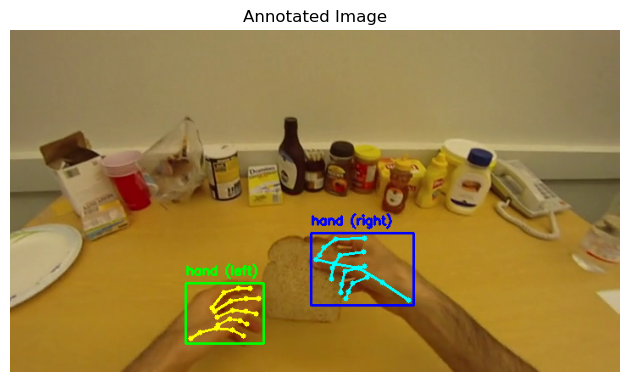

In [84]:
import cv2
import matplotlib.pyplot as plt
xml_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\xml_labels'
image_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\gtea_png\gtea_png\png'
actions_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\actions-20241207T081235Z-001\actions'
# Initialize the dataset
dataset = HandKeypointDataset(xml_path=xml_dir, image_dir=image_dir)

# Load a single sample (e.g., the first one)
image, annotation = dataset[0]

# Plot annotations
plotted = dataset.plot_annotations(image.copy(), annotation['boxes'], annotation['keypoints'])

# OpenCV images are BGR by default, convert to RGB for Matplotlib
plotted_rgb = cv2.cvtColor(plotted, cv2.COLOR_BGR2RGB)

# Display using Matplotlib
plt.imshow(plotted_rgb)
plt.title("Annotated Image")
plt.axis('off')
plt.tight_layout()
plt.show()


In [140]:
import os
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import matplotlib.pyplot as plt

class HandKeypointDataset(Dataset):
    def __init__(self, xml_path='xml_labels', image_dir='png', transform=None):
        """
        Args:
            xml_path (str): Path to the XML annotation folder.
            image_dir (str): Directory containing corresponding image files.
            transform (callable, optional): Transform to be applied on the images.
        """
        self.xml_path = xml_path
        self.image_dir = image_dir
        self.transform = transform
        self.annotations = self.parse_xml()

    def parse_xml(self):
        """Parses the XML file and extracts annotations."""
        complete_dataset = []

        for xml_name in os.listdir(self.xml_path): 
            if not xml_name.endswith('.xml'):
                continue
            xml_path = os.path.join(self.xml_path, xml_name)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            num_annos = len(root.findall('image'))
            all_annos = root.findall('image')
            print(f"Parsing {num_annos} total annotations for {xml_name}")
            
            for i in range(num_annos):
                boxes = {'left':[], 'right':[]}
                keypoints = {'left':{}, 'right':{}}

                curr_annos = []
                # Match frames by ID
                for anno in all_annos: 
                    try:
                        if int(anno.get('id')) == int(all_annos[i].get('id')):
                            curr_annos.append(anno)
                    except ValueError:
                        # If IDs are like 'frame_XXX'
                        if int(anno.get('id').replace('frame_', '')) == int(all_annos[i].get('id').replace('frame_', '')):
                            curr_annos.append(anno)

                # Extract hand_type attribute from the box to determine left or right
                # We assume each annotation has a 'hand_type' attribute
                # annos dict: { 'left': anno_for_left_hand, 'right': anno_for_right_hand }
                if len(curr_annos) < 2:
                    # If we don't have both left and right hands, skip
                    continue
                annos = {}
                for curr_anno in curr_annos:
                    box_el = curr_anno.findall('box')[0]
                    hand_type_attr = box_el.findall(".//attribute[@name='hand_type']")[0].text
                    annos[hand_type_attr] = curr_anno
                
                if len(annos.keys()) < 2:
                    continue

                width = int(annos['left'].get('width'))
                height = int(annos['right'].get('height'))

                # Parse boxes and keypoints
                for anno_side, anno_val in annos.items():
                    for box in anno_val.findall('box'):
                        xtl = float(box.get('xtl'))
                        ytl = float(box.get('ytl'))
                        xbr = float(box.get('xbr'))
                        ybr = float(box.get('ybr'))
                        label = box.get('label', 'hand')

                        boxes[anno_side].append({'label': label, 'bbox': [xtl, ytl, xbr, ybr]})

                    for polyline in anno_val.findall('polyline'):
                        label = polyline.get('label')
                        points = [
                            tuple(map(float, point.split(',')))
                            for point in polyline.get('points').split(';') if point.strip()
                        ]
                        keypoints[anno_side][label] = points

                complete_dataset.append(
                    {
                        'id': annos['left'].get('id'),
                        'video_name': xml_name.replace('.xml', ''),
                        'frame_name': annos['left'].get('name'),
                        'width': width,
                        'height': height,
                        'boxes': boxes,
                        'keypoints': keypoints
                    }
                )

        return complete_dataset

    def __len__(self):
        return len(self.annotations)
    
    def plot_annotations(self, image, boxes, keypoints):
        """
        Plots bounding boxes and keypoints on the image using OpenCV.

        Args:
            image (np.array): BGR image array.
            boxes (dict): {'left': [{'label':..., 'bbox':[x1,y1,x2,y2]}, ...], 'right':[...] }
            keypoints (dict): {'left':{'finger_name':[(x,y),...], ...}, 'right':{...}}
        """
        # Draw boxes
        for hand_side, hand_boxes in boxes.items():
            for box_info in hand_boxes:
                x_min, y_min, x_max, y_max = map(int, box_info['bbox'])
                label = box_info['label']
                color = (0, 255, 0) if hand_side == 'left' else (255, 0, 0)
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
                cv2.putText(image, f"{label} ({hand_side})", (x_min, y_min - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Draw keypoints
        for hand_side, hand_keypoints in keypoints.items():
            for finger, points in hand_keypoints.items():
                color = (0, 255, 255) if hand_side == 'left' else (255, 255, 0)
                for point in points:
                    x, y = map(int, point)
                    cv2.circle(image, (x, y), 3, color, -1)
                for i in range(len(points) - 1):
                    pt1 = tuple(map(int, points[i]))
                    pt2 = tuple(map(int, points[i + 1]))
                    cv2.line(image, pt1, pt2, color, 2)
        return image 

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_path = os.path.join(self.image_dir, annotation['video_name'], annotation['frame_name'] + '.png')
        image = cv2.imread(image_path)

        # Apply transform if needed
        if self.transform:
            image = self.transform(image)

        return image, annotation


def show_image(image, title="Image"):
    # Convert BGR to RGB for matplotlib
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(rgb_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

def crop_image_by_boxes(image, boxes, margin=10):
    """
    Given an image and a dictionary of boxes {'left': [...], 'right': [...]},
    compute a combined bounding box and crop the image around it.
    """
    all_coords = []
    for hand_side, hand_boxes in boxes.items():
        for b in hand_boxes:
            x1, y1, x2, y2 = b['bbox']
            all_coords.append((x1,y1))
            all_coords.append((x2,y2))

    if len(all_coords) == 0:
        # No boxes, return original image
        return image

    xs = [c[0] for c in all_coords]
    ys = [c[1] for c in all_coords]

    min_x = max(int(min(xs) - margin), 0)
    min_y = max(int(min(ys) - margin), 0)
    max_x = min(int(max(xs) + margin), image.shape[1]-1)
    max_y = min(int(max(ys) + margin), image.shape[0]-1)

    cropped = image[min_y:max_y+1, min_x:max_x+1]
    return cropped, (min_x, min_y, max_x, max_y)


# Initialize dataset
xml_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\xml_labels'
image_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\gtea_png\gtea_png\png'
actions_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\actions-20241207T081235Z-001\actions'
dataset = HandKeypointDataset(xml_path=xml_dir, image_dir=image_dir)


Parsing 1633 total annotations for S1_Cheese_C1.xml
Parsing 1831 total annotations for S1_Coffee_C1.xml
Parsing 1941 total annotations for S1_CofHoney_C1.xml
Parsing 1231 total annotations for S1_Hotdog_C1.xml
Parsing 2165 total annotations for S1_Pealate_C1.xml
Parsing 2408 total annotations for S1_Peanut_C1.xml
Parsing 2708 total annotations for S1_Tea_C1.xml
Parsing 1114 total annotations for S2_Cheese_C1.xml
Parsing 2911 total annotations for S2_Coffee_C1.xml
Parsing 1314 total annotations for S2_CofHoney_C1.xml
Parsing 1471 total annotations for S2_Hotdog_C1.xml
Parsing 2006 total annotations for S2_Pealate_C1.xml
Parsing 2395 total annotations for S2_Peanut_C1.xml
Parsing 1938 total annotations for S2_Tea_C1.xml
Parsing 1690 total annotations for S3_Cheese_C1.xml
Parsing 2076 total annotations for S3_Coffee_C1.xml
Parsing 1560 total annotations for S3_CofHoney_C1.xml
Parsing 1655 total annotations for S3_Hotdog_C1.xml
Parsing 2206 total annotations for S3_Pealate_C1.xml
Parsing 1

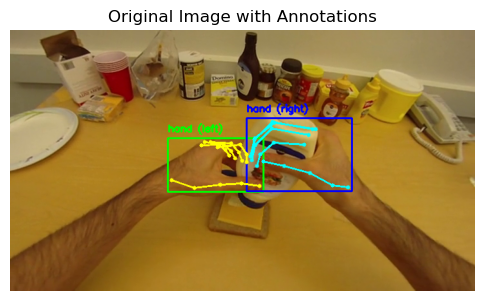

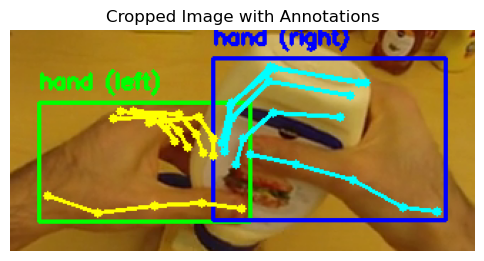

In [ ]:
if len(dataset) == 0:
    print("No annotations found. Check your paths and data.")
else:
    # Take the first sample
    image, annotation = dataset[500]
    boxes = annotation['boxes']
    keypoints = annotation['keypoints']

    # Visualize original image with annotations
    original_with_anno = dataset.plot_annotations(image.copy(), boxes, keypoints)
    show_image(original_with_anno, "Original Image with Annotations")

    # Crop the image around all bounding boxes
    cropped_image, (min_x, min_y, max_x, max_y) = crop_image_by_boxes(image, boxes, margin=20)
    # Adjust boxes/keypoints to the cropped frame of reference
    # This step is optional if you just want to visualize the cropped region.
    # But if you want to redraw them accurately:
    adjusted_boxes = {}
    for hand_side, hand_boxes in boxes.items():
        adjusted_boxes[hand_side] = []
        for b in hand_boxes:
            x1, y1, x2, y2 = b['bbox']
            # Shift by min_x, min_y
            new_box = {
                'label': b['label'],
                'bbox': [x1 - min_x, y1 - min_y, x2 - min_x, y2 - min_y]
            }
            adjusted_boxes[hand_side].append(new_box)

    adjusted_keypoints = {}
    for hand_side, hand_kps in keypoints.items():
        adjusted_keypoints[hand_side] = {}
        for finger, points in hand_kps.items():
            new_points = []
            for (x,y) in points:
                new_points.append((x - min_x, y - min_y))
            adjusted_keypoints[hand_side][finger] = new_points

    cropped_with_anno = dataset.plot_annotations(cropped_image.copy(), adjusted_boxes, adjusted_keypoints)
    show_image(cropped_with_anno, "Cropped Image with Annotations")


Parsing 1633 total annotations for S1_Cheese_C1.xml
Parsing 1831 total annotations for S1_Coffee_C1.xml
Parsing 1941 total annotations for S1_CofHoney_C1.xml
Parsing 1231 total annotations for S1_Hotdog_C1.xml
Parsing 2165 total annotations for S1_Pealate_C1.xml
Parsing 2408 total annotations for S1_Peanut_C1.xml
Parsing 2708 total annotations for S1_Tea_C1.xml
Parsing 1114 total annotations for S2_Cheese_C1.xml
Parsing 2911 total annotations for S2_Coffee_C1.xml
Parsing 1314 total annotations for S2_CofHoney_C1.xml
Parsing 1471 total annotations for S2_Hotdog_C1.xml
Parsing 2006 total annotations for S2_Pealate_C1.xml
Parsing 2395 total annotations for S2_Peanut_C1.xml
Parsing 1938 total annotations for S2_Tea_C1.xml
Parsing 1690 total annotations for S3_Cheese_C1.xml
Parsing 2076 total annotations for S3_Coffee_C1.xml
Parsing 1560 total annotations for S3_CofHoney_C1.xml
Parsing 1655 total annotations for S3_Hotdog_C1.xml
Parsing 2206 total annotations for S3_Pealate_C1.xml
Parsing 1

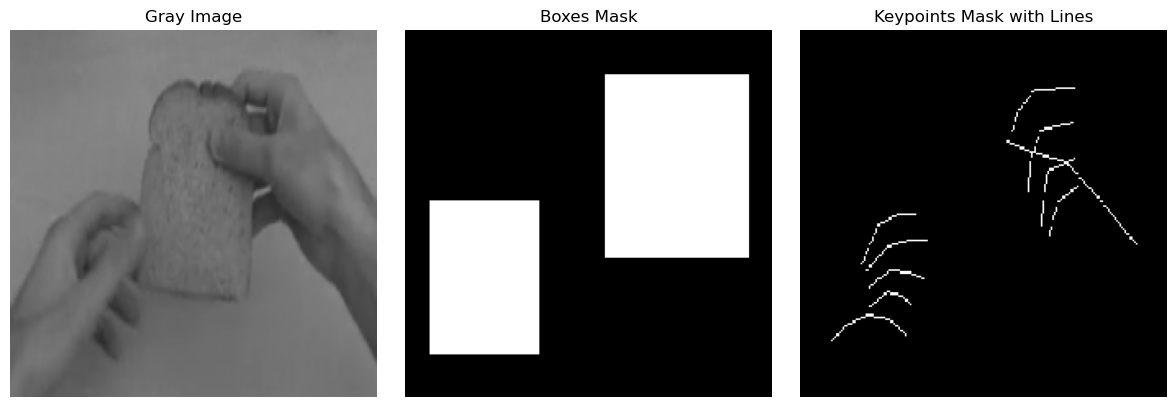

Action: 10


In [ ]:
import os
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image

CROP_SIZE = 224
MARGIN = 20

class HandKeypointDataset(Dataset):
    def __init__(self, xml_path='xml_labels', image_dir='png', actions_dir='actions', transform=None, action_mapping=None):
        """
        This dataset:
        - Parses XML annotations.
        - Maps `frame_id` to the corresponding line in the action file.
        - Crops the image around bounding boxes.
        - Returns grayscale images, masks, and actions.
        """
        self.xml_path = xml_path
        self.image_dir = image_dir
        self.actions_dir = actions_dir
        self.transform = transform

        # Default action mapping if none provided
        self.action_mapping = action_mapping or {
            'take': 0, 'open': 1, 'pour': 2, 'close': 3, 'shake': 4,
            'scoop': 5, 'stir': 6, 'put': 7, 'fold': 8, 'spread': 9, 'background': 10
        }

        self.annotations = self.parse_data()

    def parse_data(self):
        complete_dataset = []
        for xml_name in os.listdir(self.xml_path):
            if not xml_name.endswith('.xml'):
                continue

            xml_file_path = os.path.join(self.xml_path, xml_name)
            tree = ET.parse(xml_file_path)
            root = tree.getroot()
            video_name = xml_name.replace('.xml', '')

            # Load actions for this video
            actions_file = os.path.join(self.actions_dir, video_name + ".txt")
            if os.path.exists(actions_file):
                with open(actions_file, "r") as f:
                    actions = f.read().strip().splitlines()
            else:
                actions = []

            # Parse XML for frames
            for image_node in root.findall('image'):
                frame_id_str = image_node.get('id')  # e.g., "frame_000941"
                frame_id = int(''.join(filter(str.isdigit, frame_id_str)))

                # Get action for the frame, default to 'background' if out of range
                action_str = actions[frame_id] if frame_id < len(actions) else 'background'
                action = self.action_mapping.get(action_str, self.action_mapping['background'])

                # Collect bounding box and keypoints information
                boxes = []
                keypoints = {}
                for box in image_node.findall('box'):
                    xtl = float(box.get('xtl'))
                    ytl = float(box.get('ytl'))
                    xbr = float(box.get('xbr'))
                    ybr = float(box.get('ybr'))
                    boxes.append([xtl, ytl, xbr, ybr])

                for polyline in image_node.findall('polyline'):
                    label = polyline.get('label')
                    points = [
                        tuple(map(float, p.split(',')))
                        for p in polyline.get('points').split(';') if p.strip()
                    ]
                    keypoints[label] = points

                # Append annotation
                complete_dataset.append({
                    'frame_id': frame_id,
                    'video_name': video_name,
                    'boxes': boxes,
                    'keypoints': keypoints,
                    'action': action
                })

        return complete_dataset

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image_path = os.path.join(self.image_dir, ann['video_name'], f"frame_{ann['frame_id']:06d}.png")
        image = cv2.imread(image_path)

        if image is None:
            image = np.zeros((CROP_SIZE, CROP_SIZE, 3), dtype=np.uint8)

        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Resize to CROP_SIZE
        gray_image = cv2.resize(gray_image, (CROP_SIZE, CROP_SIZE))

        # Transform if needed
        if self.transform:
            gray_image = self.transform(Image.fromarray(gray_image))
        else:
            gray_image = torch.from_numpy(gray_image).unsqueeze(0).float()

        # Create dummy masks (you can enhance this as needed)
        boxes_mask = np.zeros((CROP_SIZE, CROP_SIZE), dtype=np.uint8)
        keypoints_mask = np.zeros((CROP_SIZE, CROP_SIZE), dtype=np.uint8)

        # Stack grayscale image and masks into 3-channel
        final_stack = torch.cat([gray_image, torch.from_numpy(boxes_mask).unsqueeze(0).float(),
                                 torch.from_numpy(keypoints_mask).unsqueeze(0).float()], dim=0)

        return gray_image, boxes_mask, keypoints_mask, final_stack, ann['action']


def visualize_sample(final_stack):
    if torch.is_tensor(final_stack):
        final_stack = final_stack.cpu().numpy()

    gray = final_stack[0]
    boxes_mask = final_stack[1]
    keypoints_mask = final_stack[2]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(gray, cmap='gray')
    plt.title("Gray Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(boxes_mask, cmap='gray')
    plt.title("Boxes Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(keypoints_mask, cmap='gray')
    plt.title("Keypoints Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Example usage
xml_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\xml_labels'
image_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\gtea_png\gtea_png\png'
actions_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\actions'

dataset = HandKeypointDataset(xml_path=xml_dir, image_dir=image_dir, actions_dir=actions_dir)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

if len(dataset) == 0:
    print("No annotations found. Check your paths and data.")
else:
    for gray_image, boxes_mask, keypoints_mask, final_stack, action in dataloader:
        visualize_sample(final_stack)
        print("Action:", action)
        break


In [175]:
import os
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image

CROP_SIZE = 224
MARGIN = 20

class HandKeypointDataset(Dataset):
    def __init__(self, xml_path='xml_labels', image_dir='png', actions_dir='actions', transform=None, action_mapping=None):
        """
        This dataset:
        - Parses XML annotations.
        - Maps `frame_id` to the corresponding line in the action file.
        - Crops the image around bounding boxes.
        - Returns grayscale images, masks, and actions.
        """
        self.xml_path = xml_path
        self.image_dir = image_dir
        self.actions_dir = actions_dir
        self.transform = transform

        # Default action mapping if none provided
        self.action_mapping = action_mapping or {
            'take': 0, 'open': 1, 'pour': 2, 'close': 3, 'shake': 4,
            'scoop': 5, 'stir': 6, 'put': 7, 'fold': 8, 'spread': 9, 'background': 10
        }

        self.annotations = self.parse_data()

    def parse_data(self):
        complete_dataset = []
        for xml_name in os.listdir(self.xml_path):
            if not xml_name.endswith('.xml'):
                continue

            xml_file_path = os.path.join(self.xml_path, xml_name)
            tree = ET.parse(xml_file_path)
            root = tree.getroot()
            video_name = xml_name.replace('.xml', '')

            # Load actions for this video
            actions_file = os.path.join(self.actions_dir, video_name + ".txt")
            if os.path.exists(actions_file):
                with open(actions_file, "r") as f:
                    actions = f.read().strip().splitlines()
            else:
                actions = []

            # Parse XML for frames
            for image_node in root.findall('image'):
                frame_id_str = image_node.get('id')  # e.g., "frame_000941"
                frame_id = int(''.join(filter(str.isdigit, frame_id_str)))

                # Get action for the frame, default to 'background' if out of range
                action_str = actions[frame_id] if frame_id < len(actions) else 'background'
                action = self.action_mapping.get(action_str, self.action_mapping['background'])

                # Collect bounding box and keypoints information
                boxes = []
                keypoints = {}
                for box in image_node.findall('box'):
                    xtl = float(box.get('xtl'))
                    ytl = float(box.get('ytl'))
                    xbr = float(box.get('xbr'))
                    ybr = float(box.get('ybr'))
                    boxes.append([xtl, ytl, xbr, ybr])

                for polyline in image_node.findall('polyline'):
                    label = polyline.get('label')
                    points = [
                        tuple(map(float, p.split(',')))
                        for p in polyline.get('points').split(';') if p.strip()
                    ]
                    keypoints[label] = points

                # Append annotation
                complete_dataset.append({
                    'frame_id': frame_id,
                    'video_name': video_name,
                    'boxes': boxes,
                    'keypoints': keypoints,
                    'action': action
                })

        return complete_dataset

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image_path = os.path.join(self.image_dir, ann['video_name'], f"frame_{ann['frame_id']:06d}.png")
        image = cv2.imread(image_path)

        if image is None:
            image = np.zeros((CROP_SIZE, CROP_SIZE, 3), dtype=np.uint8)

        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Resize to CROP_SIZE
        gray_image = cv2.resize(gray_image, (CROP_SIZE, CROP_SIZE))

        # Transform if needed
        if self.transform:
            gray_image = self.transform(Image.fromarray(gray_image))
        else:
            gray_image = torch.from_numpy(gray_image).unsqueeze(0).float()

        # Create dummy masks (replace with actual masks if necessary)
        boxes_mask = np.zeros((CROP_SIZE, CROP_SIZE), dtype=np.uint8)
        keypoints_mask = np.zeros((CROP_SIZE, CROP_SIZE), dtype=np.uint8)

        # Convert masks to tensors
        boxes_mask_tensor = torch.from_numpy(boxes_mask).unsqueeze(0).float()
        keypoints_mask_tensor = torch.from_numpy(keypoints_mask).unsqueeze(0).float()

        # Stack grayscale image and masks into a 3-channel tensor
        final_stack = torch.cat([gray_image, boxes_mask_tensor, keypoints_mask_tensor], dim=0)

        return gray_image, boxes_mask_tensor, keypoints_mask_tensor, final_stack, ann['action']

    def visualize_sample(final_stack):
        if torch.is_tensor(final_stack):
            final_stack = final_stack.cpu().numpy()

        # Ensure final_stack has three channels
        if final_stack.shape[0] < 3:
            raise ValueError("Final stack must have three channels: [gray, boxes_mask, keypoints_mask]")

        gray = final_stack[0][0]
        boxes_mask = final_stack[0][1]
        keypoints_mask = final_stack[0][2]

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(gray, cmap='gray')
        plt.title("Gray Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(boxes_mask, cmap='gray')
        plt.title("Boxes Mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(keypoints_mask, cmap='gray')
        plt.title("Keypoints Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()



# Example usage
xml_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\xml_labels'
image_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\gtea_png\gtea_png\png'
actions_dir = r'C:\Users\abdul\Desktop\visionrd\AI-Hackathon24\data\actions'

dataset = HandKeypointDataset(xml_path=xml_dir, image_dir=image_dir, actions_dir=actions_dir)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

if len(dataset) == 0:
    print("No annotations found. Check your paths and data.")
else:
    for gray_image, boxes_mask, keypoints_mask, final_stack, action in dataloader:
        visualize_sample(final_stack)
        print("Action:", action)
        break


IndexError: index 1 is out of bounds for axis 0 with size 1

In [174]:
final_stack[0].shape

torch.Size([3, 224, 224])